# **Neural Style Transfer**

We will transfer the style from an image to another image and generate a new image with the new style using TensorFlow, Keras, and VGG19.

**Import Libraries**

In [1]:
from tensorflow import keras
from IPython.display import Image, display
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

**Load The Base Image And The Style Image**

In [2]:
base_image_path = keras.utils.get_file("fiu.jpg", "https://www.slamstox.com/wp-content/uploads/2022/06/FIU.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")

935806/935806 [==============================] - 0s 0us/step


**Display The Base Image And The Style Image**

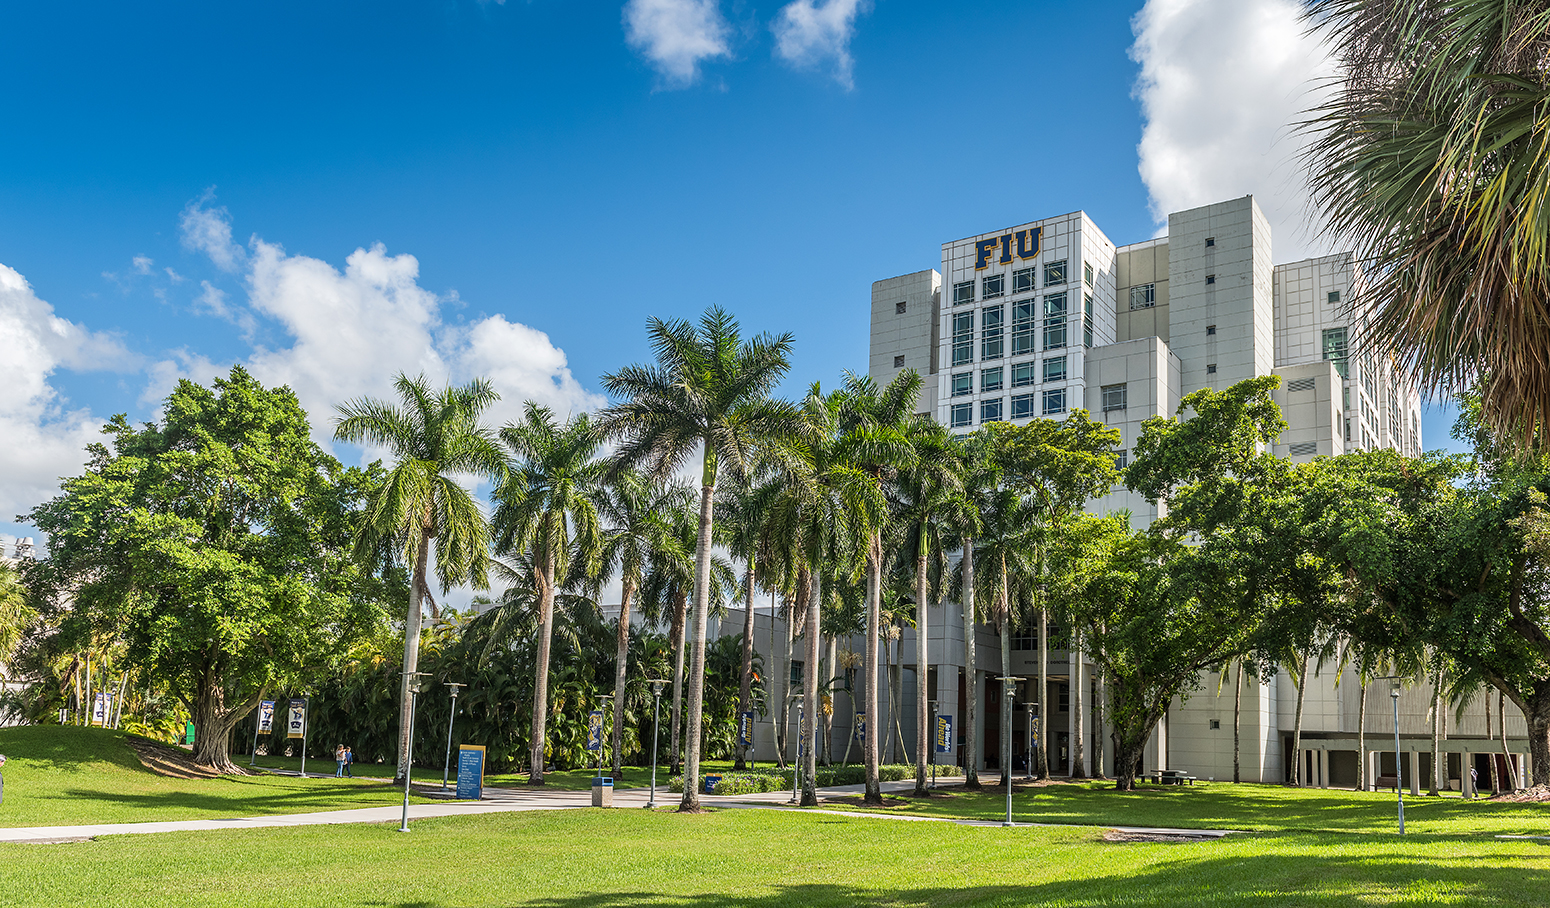

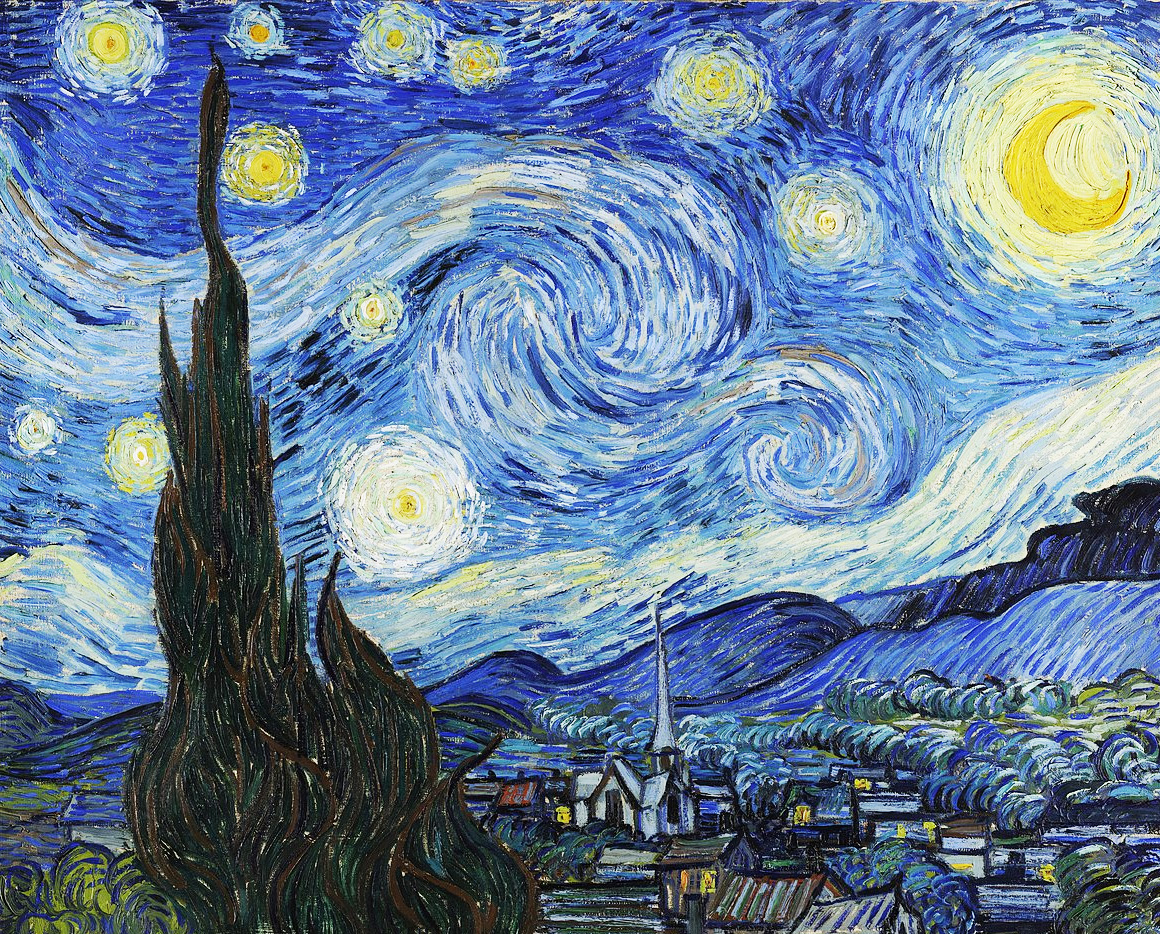

In [3]:
display(Image(base_image_path))
display(Image(style_reference_image_path))

**Define The Generated Image**

In [4]:
result_prefix = "fiu_generated"

**Initialize The Weights Of Different Loss Components**

In [5]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

**Initialize The Dimensions Of The Generated Image**

In [6]:
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

**Define Function To Preprocess Image**

In [7]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

**Define Function To Deprocess Image**

In [8]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

**Define Gram Matrix Function**

The gram matrix of an image tensor (feature-wise outer product).

In [9]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

**Define Style Loss Function**

We will design the style_loss function to maintainthe style of the reference image in the generated image. It will be based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image.

In [10]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Define Content Loss Function**

We will design the content_loss function to maintain the "content" of the base image in the generated image.

In [11]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

**Define Total Variation Loss Function**

We will design the total_variation_loss function to keep the generated image locally coherent.

In [12]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Build VGG19 Model**

We will build a VGG19 model loaded with pre-trained ImageNet weights.

In [13]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


**Get Symbolic Outputs Of Each Key Layer**

In [14]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

**Set Model To Return The Activation Values For Every VGG19 Layer**

In [15]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**Define Style Loss Layers**

In [16]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

**Define Content Loss Layer**

In [17]:
content_layer_name = "block5_conv2"

**Define Compute Loss Function**

In [18]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Define Compute Loss And Grads Function**

In [19]:
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

**Define Optimizer**

In [20]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

**Train Model**

In [21]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=12923.67
Iteration 200: loss=9311.77
Iteration 300: loss=8136.08
Iteration 400: loss=7547.05
Iteration 500: loss=7183.66
Iteration 600: loss=6931.61
Iteration 700: loss=6744.02
Iteration 800: loss=6597.88
Iteration 900: loss=6480.40
Iteration 1000: loss=6384.05
Iteration 1100: loss=6303.63
Iteration 1200: loss=6235.42
Iteration 1300: loss=6176.64
Iteration 1400: loss=6125.39
Iteration 1500: loss=6080.53
Iteration 1600: loss=6040.94
Iteration 1700: loss=6005.78
Iteration 1800: loss=5974.34
Iteration 1900: loss=5946.03
Iteration 2000: loss=5920.44
Iteration 2100: loss=5897.21
Iteration 2200: loss=5876.09
Iteration 2300: loss=5856.84
Iteration 2400: loss=5839.24
Iteration 2500: loss=5823.09
Iteration 2600: loss=5808.24
Iteration 2700: loss=5794.52
Iteration 2800: loss=5781.81
Iteration 2900: loss=5770.01
Iteration 3000: loss=5759.04
Iteration 3100: loss=5748.82
Iteration 3200: loss=5739.28
Iteration 3300: loss=5730.37
Iteration 3400: loss=5722.06
Iteration 3500: loss=5

**Display Generated Image**

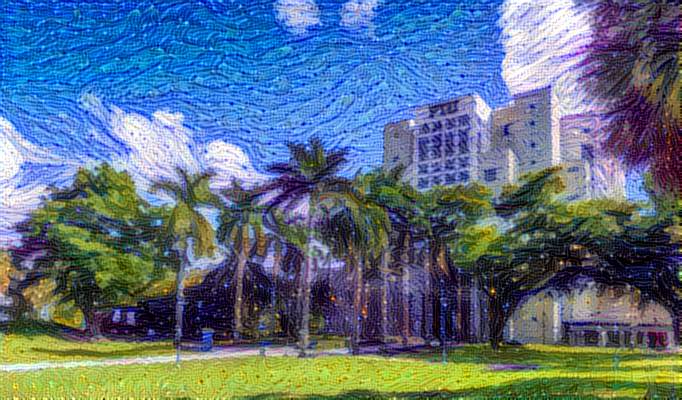

In [22]:
display(Image(result_prefix + "_at_iteration_4000.png"))